
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
import gym
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.01398655 -0.2056357   0.0426987   0.32653782] 0 1.0 False {}
state, action, reward, done, info
[ 0.00987384 -0.01114686  0.04922946  0.04762006] 1 1.0 False {}
state, action, reward, done, info
[ 0.0096509   0.18323588  0.05018186 -0.22913317] 1 1.0 False {}
state, action, reward, done, info
[ 0.01331562 -0.01256593  0.0455992   0.07894709] 0 1.0 False {}
state, action, reward, done, info
[ 0.0130643   0.18187368  0.04717814 -0.19900764] 1 1.0 False {}
state, action, reward, done, info
[ 0.01670177  0.37629022  0.04319799 -0.47644273] 1 1.0 False {}
state, action, reward, done, info
[ 0.02422758  0.57077644  0.03366913 -0.75520366] 1 1.0 False {}
state, action, reward, done, info
[ 0.03564311  0.76541848  0.01856506 -1.0371044 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.05095148  0.96028881 -0.00217703 -1.3239017 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.07015725  1.1554382  -0.02865506 -1.61726513] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1554381956007445 -1.6172651297814429


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [7]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [10]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [11]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [12]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [13]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [14]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [15]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [16]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 200                # experience mini-batch size
learning_rate = 0.001           # learning rate for adam

In [18]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #     #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/QGAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 27.0 Average reward fake: 0.4917689561843872 Average reward real: 0.4974210858345032 Training q_loss: 0.4022 Training g_loss: 0.7097 Training d_loss: 1.3780 Explore P: 0.9973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 11.0 Average reward fake: 0.491934597492218 Average reward real: 0.5063025951385498 Training q_loss: 0.5998 Training g_loss: 0.7094 Training d_loss: 1.3588 Explore P: 0.9962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 25.0 Average reward fake: 0.5019077062606812 Average reward real: 0.5257543921470642 Training q_loss: 2.4548 Training g_loss: 0.6893 Training d_loss: 1.3493 Explore P: 0.9938
-

-------------------------------------------------------------------------------
Episode: 23 Total reward: 19.0 Average reward fake: 0.48451000452041626 Average reward real: 0.4228098392486572 Training q_loss: 21.6582 Training g_loss: 0.7260 Training d_loss: 1.5638 Explore P: 0.9605
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 13.0 Average reward fake: 0.3363305330276489 Average reward real: 0.461475670337677 Training q_loss: 20.5954 Training g_loss: 1.0896 Training d_loss: 1.1858 Explore P: 0.9593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 14.0 Average reward fake: 0.27221643924713135 Average reward real: 0.5643633604049683 Training q_loss: 16.5870 Training g_loss: 1.3014 Training d_loss: 0.8914 Explore P: 

-------------------------------------------------------------------------------
Episode: 46 Total reward: 9.0 Average reward fake: 0.4382480978965759 Average reward real: 0.52138751745224 Training q_loss: 20.8548 Training g_loss: 0.8255 Training d_loss: 1.2382 Explore P: 0.9177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 11.0 Average reward fake: 0.4399460554122925 Average reward real: 0.5172171592712402 Training q_loss: 28.2027 Training g_loss: 0.8226 Training d_loss: 1.2481 Explore P: 0.9167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 52.0 Average reward fake: 0.570233166217804 Average reward real: 0.47141799330711365 Training q_loss: 27.0469 Training g_loss: 0.5622 Training d_loss: 1.6266 Explore P: 0.91

-------------------------------------------------------------------------------
Episode: 70 Total reward: 14.0 Average reward fake: 0.46557486057281494 Average reward real: 0.5311534404754639 Training q_loss: 105.3749 Training g_loss: 0.7646 Training d_loss: 1.2714 Explore P: 0.8511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 48.0 Average reward fake: 0.45271944999694824 Average reward real: 0.5381051301956177 Training q_loss: 93.8287 Training g_loss: 0.7936 Training d_loss: 1.2802 Explore P: 0.8471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 15.0 Average reward fake: 0.5234165191650391 Average reward real: 0.499440461397171 Training q_loss: 126.2427 Training g_loss: 0.6502 Training d_loss: 1.4955 Explore P

-------------------------------------------------------------------------------
Episode: 93 Total reward: 35.0 Average reward fake: 0.5146723389625549 Average reward real: 0.48132091760635376 Training q_loss: 363.2016 Training g_loss: 0.6645 Training d_loss: 1.4656 Explore P: 0.7901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 32.0 Average reward fake: 0.5272849202156067 Average reward real: 0.4839801788330078 Training q_loss: 755.1014 Training g_loss: 0.6369 Training d_loss: 1.5056 Explore P: 0.7876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 54.0 Average reward fake: 0.4417085349559784 Average reward real: 0.5401912927627563 Training q_loss: 1145.3302 Training g_loss: 0.8224 Training d_loss: 1.2337 Explore

-------------------------------------------------------------------------------
Episode: 116 Total reward: 80.0 Average reward fake: 0.47100868821144104 Average reward real: 0.5164476633071899 Training q_loss: 3293.2400 Training g_loss: 0.7531 Training d_loss: 1.3301 Explore P: 0.7118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 48.0 Average reward fake: 0.4836510717868805 Average reward real: 0.5363444685935974 Training q_loss: 3112.0725 Training g_loss: 0.7269 Training d_loss: 1.2930 Explore P: 0.7085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 37.0 Average reward fake: 0.4839116036891937 Average reward real: 0.5314309597015381 Training q_loss: 2672.3772 Training g_loss: 0.7283 Training d_loss: 1.3026 Ex

-------------------------------------------------------------------------------
Episode: 139 Total reward: 73.0 Average reward fake: 0.49302875995635986 Average reward real: 0.53310227394104 Training q_loss: 24696.1094 Training g_loss: 0.7072 Training d_loss: 1.3561 Explore P: 0.6325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 22.0 Average reward fake: 0.489277720451355 Average reward real: 0.5368011593818665 Training q_loss: 54955.4805 Training g_loss: 0.7149 Training d_loss: 1.3393 Explore P: 0.6311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 26.0 Average reward fake: 0.526267409324646 Average reward real: 0.5421122908592224 Training q_loss: 31421.2852 Training g_loss: 0.6421 Training d_loss: 1.3776 Exp

-------------------------------------------------------------------------------
Episode: 163 Total reward: 186.0 Average reward fake: 0.4376373291015625 Average reward real: 0.522260844707489 Training q_loss: 201312.7031 Training g_loss: 0.8303 Training d_loss: 1.2485 Explore P: 0.5035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 71.0 Average reward fake: 0.42639851570129395 Average reward real: 0.5815361738204956 Training q_loss: 345677.3750 Training g_loss: 0.8586 Training d_loss: 1.1147 Explore P: 0.5000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 10.0 Average reward fake: 0.47906845808029175 Average reward real: 0.5713537335395813 Training q_loss: 232304.8594 Training g_loss: 0.7464 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 194 Total reward: 151.0 Average reward fake: 0.5090826153755188 Average reward real: 0.5555875301361084 Training q_loss: 210020.7031 Training g_loss: 0.6764 Training d_loss: 1.3055 Explore P: 0.3470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 195 Total reward: 191.0 Average reward fake: 0.5194183588027954 Average reward real: 0.46159303188323975 Training q_loss: 210998.1562 Training g_loss: 0.6552 Training d_loss: 1.5418 Explore P: 0.3406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 196 Total reward: 50.0 Average reward fake: 0.48584622144699097 Average reward real: 0.4391977787017822 Training q_loss: 528224.3125 Training g_loss: 0.7219 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 232 Total reward: 2.0 Average reward fake: 0.4475342035293579 Average reward real: 0.5510284900665283 Training q_loss: 156381.5469 Training g_loss: 0.8347 Training d_loss: 1.2301 Explore P: 0.2167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 183.0 Average reward fake: 0.44028496742248535 Average reward real: 0.584104061126709 Training q_loss: 132492.4219 Training g_loss: 0.8716 Training d_loss: 1.1620 Explore P: 0.2130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 197.0 Average reward fake: 0.41670432686805725 Average reward real: 0.6361343860626221 Training q_loss: 117968.3125 Training g_loss: 0.8755 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 266 Total reward: 31.0 Average reward fake: 0.5474010109901428 Average reward real: 0.4769713580608368 Training q_loss: 73833.3984 Training g_loss: 0.6075 Training d_loss: 1.5875 Explore P: 0.1391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 13.0 Average reward fake: 0.45548903942108154 Average reward real: 0.47134673595428467 Training q_loss: 69889.3359 Training g_loss: 0.7864 Training d_loss: 1.3808 Explore P: 0.1363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 22.0 Average reward fake: 0.45460274815559387 Average reward real: 0.5415641665458679 Training q_loss: 66967.7500 Training g_loss: 0.7886 Training d_loss: 1.23

-------------------------------------------------------------------------------
Episode: 308 Total reward: 25.0 Average reward fake: 0.5945748090744019 Average reward real: 0.3525984287261963 Training q_loss: 19124.5547 Training g_loss: 0.5289 Training d_loss: 2.0632 Explore P: 0.0856
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 309 Total reward: 197.0 Average reward fake: 0.49929535388946533 Average reward real: 0.4756975471973419 Training q_loss: 12098.5273 Training g_loss: 0.6946 Training d_loss: 1.5265 Explore P: 0.0841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 53.0 Average reward fake: 0.45911309123039246 Average reward real: 0.5491287708282471 Training q_loss: 8791.7354 Training g_loss: 0.7790 Training d_loss: 1.228

-------------------------------------------------------------------------------
Episode: 339 Total reward: 149.0 Average reward fake: 0.484218567609787 Average reward real: 0.5374886393547058 Training q_loss: 5218.3242 Training g_loss: 0.7252 Training d_loss: 1.2941 Explore P: 0.0585
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 340 Total reward: 81.0 Average reward fake: 0.47864872217178345 Average reward real: 0.4959442913532257 Training q_loss: 2906.5244 Training g_loss: 0.7369 Training d_loss: 1.3860 Explore P: 0.0581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 341 Total reward: 82.0 Average reward fake: 0.49391260743141174 Average reward real: 0.5015394687652588 Training q_loss: 4528.2905 Training g_loss: 0.7058 Training d_loss: 1.3842 E

-------------------------------------------------------------------------------
Episode: 364 Total reward: 54.0 Average reward fake: 0.4866287112236023 Average reward real: 0.4557715654373169 Training q_loss: 21986.6270 Training g_loss: 0.7204 Training d_loss: 1.4561 Explore P: 0.0457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 169.0 Average reward fake: 0.5324113965034485 Average reward real: 0.48566681146621704 Training q_loss: 6650.7812 Training g_loss: 0.6423 Training d_loss: 1.5433 Explore P: 0.0451
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 366 Total reward: 188.0 Average reward fake: 0.44894903898239136 Average reward real: 0.5103595852851868 Training q_loss: 2801.6499 Training g_loss: 0.8060 Training d_loss: 1.298

-------------------------------------------------------------------------------
Episode: 388 Total reward: 123.0 Average reward fake: 0.5894705653190613 Average reward real: 0.44724413752555847 Training q_loss: 3138.7776 Training g_loss: 0.5266 Training d_loss: 1.7260 Explore P: 0.0366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 389 Total reward: 168.0 Average reward fake: 0.501380443572998 Average reward real: 0.49150341749191284 Training q_loss: 2272.8074 Training g_loss: 0.6902 Training d_loss: 1.4192 Explore P: 0.0361
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 390 Total reward: 122.0 Average reward fake: 0.5372831225395203 Average reward real: 0.46230563521385193 Training q_loss: 1731.3387 Training g_loss: 0.6207 Training d_loss: 1.558

-------------------------------------------------------------------------------
Episode: 411 Total reward: 129.0 Average reward fake: 0.5081726312637329 Average reward real: 0.4943661093711853 Training q_loss: 3782.5439 Training g_loss: 0.6807 Training d_loss: 1.4382 Explore P: 0.0301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 412 Total reward: 94.0 Average reward fake: 0.5258994698524475 Average reward real: 0.5548574328422546 Training q_loss: 2699.9673 Training g_loss: 0.6437 Training d_loss: 1.3445 Explore P: 0.0299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 413 Total reward: 94.0 Average reward fake: 0.48939254879951477 Average reward real: 0.5054270029067993 Training q_loss: 4851.8506 Training g_loss: 0.7155 Training d_loss: 1.3837 E

-------------------------------------------------------------------------------
Episode: 436 Total reward: 83.0 Average reward fake: 0.4951725900173187 Average reward real: 0.45800307393074036 Training q_loss: 1796.6251 Training g_loss: 0.7048 Training d_loss: 1.5003 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 437 Total reward: 138.0 Average reward fake: 0.4578499495983124 Average reward real: 0.46063560247421265 Training q_loss: 4330.6211 Training g_loss: 0.7909 Training d_loss: 1.4227 Explore P: 0.0250
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 45.0 Average reward fake: 0.5019519925117493 Average reward real: 0.5273852348327637 Training q_loss: 2322.3352 Training g_loss: 0.7091 Training d_loss: 1.5474 

-------------------------------------------------------------------------------
Episode: 460 Total reward: 101.0 Average reward fake: 0.4824552536010742 Average reward real: 0.47948968410491943 Training q_loss: 2606.6326 Training g_loss: 0.7288 Training d_loss: 1.3988 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 461 Total reward: 91.0 Average reward fake: 0.47074049711227417 Average reward real: 0.5029746294021606 Training q_loss: 11815.8027 Training g_loss: 0.7544 Training d_loss: 1.3468 Explore P: 0.0217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 184.0 Average reward fake: 0.4721313416957855 Average reward real: 0.5353273153305054 Training q_loss: 1902.3473 Training g_loss: 0.7510 Training d_loss: 1.280

-------------------------------------------------------------------------------
Episode: 496 Total reward: 158.0 Average reward fake: 0.3833662271499634 Average reward real: 0.6328793168067932 Training q_loss: 4494.7612 Training g_loss: 1.0088 Training d_loss: 1.0329 Explore P: 0.0167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 497 Total reward: 161.0 Average reward fake: 0.20346897840499878 Average reward real: 0.8343630433082581 Training q_loss: 2038.0688 Training g_loss: 1.9270 Training d_loss: 0.5178 Explore P: 0.0166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 498 Total reward: 170.0 Average reward fake: 0.4736488461494446 Average reward real: 0.5017111301422119 Training q_loss: 782.9116 Training g_loss: 0.7474 Training d_loss: 1.3437 

-------------------------------------------------------------------------------
Episode: 522 Total reward: 29.0 Average reward fake: 0.3993825912475586 Average reward real: 0.6590884327888489 Training q_loss: 5077.6470 Training g_loss: 1.1294 Training d_loss: 1.1259 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 523 Total reward: 132.0 Average reward fake: 0.612335741519928 Average reward real: 0.5857303738594055 Training q_loss: 1914.4554 Training g_loss: 0.5193 Training d_loss: 1.5924 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 525 Total reward: 155.0 Average reward fake: 0.4185461699962616 Average reward real: 0.5773323178291321 Training q_loss: 423.1342 Training g_loss: 0.9026 Training d_loss: 1.2151 Exp

-------------------------------------------------------------------------------
Episode: 565 Total reward: 7.0 Average reward fake: 0.4027729034423828 Average reward real: 0.5568724274635315 Training q_loss: 356.7235 Training g_loss: 0.9596 Training d_loss: 1.1632 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 178.0 Average reward fake: 0.4547913074493408 Average reward real: 0.5983742475509644 Training q_loss: 1393.5314 Training g_loss: 0.8304 Training d_loss: 1.2139 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 183.0 Average reward fake: 0.4868161678314209 Average reward real: 0.524340808391571 Training q_loss: 440.1767 Training g_loss: 0.7256 Training d_loss: 1.3943 Explo

-------------------------------------------------------------------------------
Episode: 593 Total reward: 197.0 Average reward fake: 0.47388526797294617 Average reward real: 0.5277266502380371 Training q_loss: 338.7945 Training g_loss: 0.7481 Training d_loss: 1.3089 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 594 Total reward: 161.0 Average reward fake: 0.5001866817474365 Average reward real: 0.5121528506278992 Training q_loss: 229.9294 Training g_loss: 0.7061 Training d_loss: 1.3961 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 186.0 Average reward fake: 0.40096718072891235 Average reward real: 0.5674469470977783 Training q_loss: 129.7850 Training g_loss: 0.9236 Training d_loss: 1.1082 E

-------------------------------------------------------------------------------
Episode: 626 Total reward: 14.0 Average reward fake: 0.41162094473838806 Average reward real: 0.5103708505630493 Training q_loss: 1440.8215 Training g_loss: 0.8951 Training d_loss: 1.2417 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 629 Total reward: 99.0 Average reward fake: 0.5212064385414124 Average reward real: 0.4891713857650757 Training q_loss: 100.8933 Training g_loss: 0.6492 Training d_loss: 1.4784 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 631 Total reward: 104.0 Average reward fake: 0.5319660902023315 Average reward real: 0.5053957104682922 Training q_loss: 398.8203 Training g_loss: 0.6356 Training d_loss: 1.4889 Exp

-------------------------------------------------------------------------------
Episode: 666 Total reward: 168.0 Average reward fake: 0.5001489520072937 Average reward real: 0.4881684184074402 Training q_loss: 133.7893 Training g_loss: 0.6968 Training d_loss: 1.5910 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 106.0 Average reward fake: 0.4596344232559204 Average reward real: 0.5786350965499878 Training q_loss: 226.8703 Training g_loss: 0.7879 Training d_loss: 1.2122 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 136.0 Average reward fake: 0.43915557861328125 Average reward real: 0.5125826001167297 Training q_loss: 457.0114 Training g_loss: 0.8226 Training d_loss: 1.2788 Ex

-------------------------------------------------------------------------------
Episode: 721 Total reward: 99.0 Average reward fake: 0.4975024163722992 Average reward real: 0.5333646535873413 Training q_loss: 458.4142 Training g_loss: 0.6974 Training d_loss: 1.3342 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 723 Total reward: 188.0 Average reward fake: 0.44410964846611023 Average reward real: 0.5297484993934631 Training q_loss: 144.1946 Training g_loss: 0.8178 Training d_loss: 1.2375 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 122.0 Average reward fake: 0.4499017000198364 Average reward real: 0.4777146875858307 Training q_loss: 124.0950 Training g_loss: 0.8062 Training d_loss: 1.3490 Exp

-------------------------------------------------------------------------------
Episode: 767 Total reward: 99.0 Average reward fake: 0.480329692363739 Average reward real: 0.49454808235168457 Training q_loss: 532.1343 Training g_loss: 0.7333 Training d_loss: 1.3650 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 68.0 Average reward fake: 0.4603535532951355 Average reward real: 0.5337213277816772 Training q_loss: 1029.1381 Training g_loss: 0.7758 Training d_loss: 1.2508 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 149.0 Average reward fake: 0.5048078298568726 Average reward real: 0.5486102104187012 Training q_loss: 229.2233 Training g_loss: 0.6836 Training d_loss: 1.3078 Expl

-------------------------------------------------------------------------------
Episode: 811 Total reward: 64.0 Average reward fake: 0.49413761496543884 Average reward real: 0.48859620094299316 Training q_loss: 1991.7723 Training g_loss: 0.7049 Training d_loss: 1.4060 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 814 Total reward: 99.0 Average reward fake: 0.49435102939605713 Average reward real: 0.515657365322113 Training q_loss: 170.0952 Training g_loss: 0.7045 Training d_loss: 1.3546 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 99.0 Average reward fake: 0.4940512776374817 Average reward real: 0.4789285957813263 Training q_loss: 271.2430 Training g_loss: 0.7052 Training d_loss: 1.4212 Exp

-------------------------------------------------------------------------------
Episode: 855 Total reward: 11.0 Average reward fake: 0.5326075553894043 Average reward real: 0.5502212047576904 Training q_loss: 73355.6328 Training g_loss: 0.6300 Training d_loss: 1.3651 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 8.0 Average reward fake: 0.4702696204185486 Average reward real: 0.5928642749786377 Training q_loss: 484171.2812 Training g_loss: 0.7544 Training d_loss: 1.1787 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 10.0 Average reward fake: 0.45641952753067017 Average reward real: 0.5541568398475647 Training q_loss: 174454.5000 Training g_loss: 0.7843 Training d_loss: 1.243

-------------------------------------------------------------------------------
Episode: 878 Total reward: 9.0 Average reward fake: 0.5605016946792603 Average reward real: 0.5472730398178101 Training q_loss: 2616538.5000 Training g_loss: 0.5789 Training d_loss: 1.4438 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 879 Total reward: 11.0 Average reward fake: 0.5030969381332397 Average reward real: 0.6203790903091431 Training q_loss: 15752035.0000 Training g_loss: 0.6870 Training d_loss: 1.1743 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 880 Total reward: 7.0 Average reward fake: 0.46152207255363464 Average reward real: 0.6337611675262451 Training q_loss: 16783194.0000 Training g_loss: 0.7732 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 901 Total reward: 7.0 Average reward fake: 0.5137425065040588 Average reward real: 0.4811767637729645 Training q_loss: 9717863.0000 Training g_loss: 0.6660 Training d_loss: 1.4554 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 9.0 Average reward fake: 0.49996182322502136 Average reward real: 0.4976405203342438 Training q_loss: 78501936.0000 Training g_loss: 0.6932 Training d_loss: 1.3956 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 8.0 Average reward fake: 0.48659956455230713 Average reward real: 0.5046184062957764 Training q_loss: 48187352.0000 Training g_loss: 0.7203 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 924 Total reward: 10.0 Average reward fake: 0.4901081919670105 Average reward real: 0.47015807032585144 Training q_loss: 86040.6406 Training g_loss: 0.7131 Training d_loss: 1.4330 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 11.0 Average reward fake: 0.48850005865097046 Average reward real: 0.46635833382606506 Training q_loss: 67759.8125 Training g_loss: 0.7164 Training d_loss: 1.4369 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 926 Total reward: 9.0 Average reward fake: 0.4907361567020416 Average reward real: 0.4774465262889862 Training q_loss: 69497792.0000 Training g_loss: 0.7118 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 947 Total reward: 11.0 Average reward fake: 0.5884255766868591 Average reward real: 0.47768568992614746 Training q_loss: 277814.3438 Training g_loss: 0.5303 Training d_loss: 1.6430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 11.0 Average reward fake: 0.4401417076587677 Average reward real: 0.5926410555839539 Training q_loss: 17462656.0000 Training g_loss: 0.8207 Training d_loss: 1.1018 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 949 Total reward: 10.0 Average reward fake: 0.34256789088249207 Average reward real: 0.7106645703315735 Training q_loss: 233661.1250 Training g_loss: 1.0713 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 970 Total reward: 47.0 Average reward fake: 0.4674396514892578 Average reward real: 0.48414576053619385 Training q_loss: 8842575.0000 Training g_loss: 0.7607 Training d_loss: 1.3581 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 65.0 Average reward fake: 0.48075225949287415 Average reward real: 0.499605268239975 Training q_loss: 1634234.7500 Training g_loss: 0.7324 Training d_loss: 1.3521 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 56.0 Average reward fake: 0.5102708339691162 Average reward real: 0.5019650459289551 Training q_loss: 4060738.2500 Training g_loss: 0.6728 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 994 Total reward: 53.0 Average reward fake: 0.4943009316921234 Average reward real: 0.48868224024772644 Training q_loss: 55000.5039 Training g_loss: 0.7047 Training d_loss: 1.4016 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 84.0 Average reward fake: 0.5098857283592224 Average reward real: 0.5122622847557068 Training q_loss: 45183.4844 Training g_loss: 0.6736 Training d_loss: 1.3844 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 39.0 Average reward fake: 0.5072852969169617 Average reward real: 0.5126875042915344 Training q_loss: 85161.8828 Training g_loss: 0.6787 Training d_loss: 1.3787

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

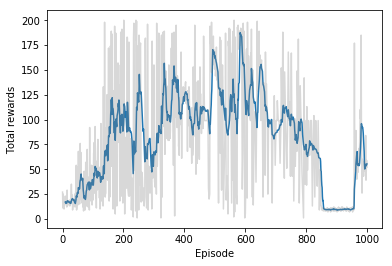

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

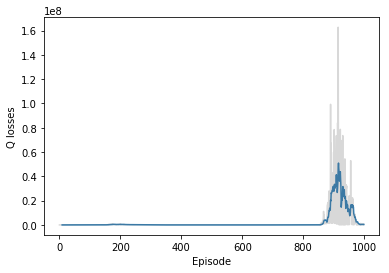

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

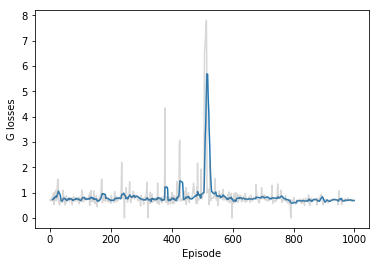

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

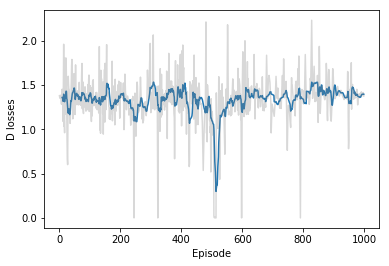

In [25]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
test_episodes = 5
test_max_steps = 2000
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/QGAN-cartpole.ckpt


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.